In [373]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import scipy.stats as sp
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
#from bayes_opt import BayesianOptimization

Here we will put all the function at the same time, then after we will execute one after another our main

In [374]:
# Function to explore the data
def explore_data(df):

    print(df.describe())
    print(df.isnull().sum())
    print(df.dtypes)

# Function for feature engineering
def engineer_features1(df):
    df.set_index('Date', inplace= True)
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek # this is a panda function that give the nmber of the date (weeknd are 5, 6) Monday is 0
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    return df

def engineer_features(df):
    # If 'Date' is not the index, set it as the index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # Extract time-based features from the index
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek  # pandas function that gives the number of the day of the week (0 is Monday)
    df['Month'] = df.index.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 correspond to Saturday and Sunday
    
    return df


# Function for data cleaning
def clean_data(df):
    df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean
    # Add other data cleaning steps here
    return df

In [375]:
def show_correlation(df, target_variable):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Select correlations related to the target variable
    target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)

    # Create a figure
    plt.figure(figsize=(8, 10))

    # Plot heatmap of the sorted target variable correlations
    sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Feature Correlation with {target_variable}')
    plt.show()

def show_cross_correlation(df, target_variable, method='spearman', title= ""):
    # Calculate the Spearman rank correlation matrix
    corr_matrix = df.corr(method=method)

    # Generate a mask for the upper triangle (optional, for aesthetics)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f'Feature Cross Correlation (Spearman){title}')
    plt.show()


In [376]:
# this function is for scalling 
def transform_data(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = []

    # Set 'Date' as the index if it's not already, assuming 'Date' is the name of your datetime column
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True)

    # Ensure 'Date' column is excluded from scaling by not adding it to X
    X = df.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1)
    y = df[target_column_name]

    scaler = StandardScaler()
    # Only scale columns that are not excluded
    X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.select_dtypes(include=[np.number]).columns, index=X.index)

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling]
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)

    print("Make sure transformation is well done:")
    print(X_final.head())
    return X_final, y

In [377]:
# Function to split the data, but this shouldn't be applied for time series as it supposes the variables as random
# so we will use the one after which is used for time series
def split_data1(X, y, test_size=0.2, random_state=203):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def split_data(X, y, dates, test_size=0.2):
    split_point = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    dates_train, dates_test = dates[:split_point], dates[split_point:]
    return X_train, X_test, y_train, y_test, dates_train, dates_test

We Use the Multiple Splits Function: This function is beneficial for thoroughly testing and validating your model across different time windows. It provides insights into how the model performs as more data becomes available, and helps you understand how stable and robust your model is under varying conditions. \\


Objective: Use this approach to adjust hyperparameters, try different model architectures, and test different feature sets to see how changes affect performance across multiple time periods.


Advantage: This method provides a comprehensive view of model performance and helps ensure that your model is not overfitting to a specific time period.

We Use the Single Last Split Function: Once you are satisfied with your model's performance and have finalized your tuning, switch to using the function that returns only the last split. This setup maximizes the amount of training data you use and tests the model on the most recent data, which is typically what you'd do in a production environment or for a final evaluation before deployment.
Objective: Prepare the model for real-world application by training it on the fullest extent of historical data available and evaluating it on the most recent, unseen data segment.
Advantage: Maximizes the use of available data and provides a realistic assessment of how the model will perform when making actual forecasts after deployment.

In [378]:
def time_series_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_indices = []
    test_indices = []
    X_train, X_test, y_train, y_test = None, None, None, None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Collect all train and test indices
        train_indices.append(train_index)
        test_indices.append(test_index)

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [379]:
###
    # we start with SVR, but it will works with others models
def train_model(X_train, y_train, technique, params):
    """
    Trains an SVR model based on the specified technique and parameters.

    :param X_train: Training feature dataset.
    :param y_train: Training target dataset.
    :param technique: Specifies the technique to use.
                      "SVR default" for default parameters, "SVR" for custom parameters.
    :param params: Dictionary of parameters for the SVR model.
    :return: Trained SVR model.
    """
    if technique == "SVR default":
        model = SVR()
    elif technique == "SVR":
        model = SVR(**params)
    else:
        raise ValueError("Unsupported technique specified.")

    model.fit(X_train, y_train)
    return model

In [380]:
def evaluate_model(model, X_test, y_test):
    """

    :type model: this is a trained model, and it's coming from the returned value of train_model
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Print the evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}")

    return predictions, mse, mae, rmse, r2

In [381]:
def perform_grid_search(X_train, y_train):  # i don't like it. it only works with SVR, but we will leave it to later
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [382]:
def perform_random_search(X_train, y_train, model, param_dist, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=203)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

In [383]:
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

In [384]:
def plotting1(predictions, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.plot(y_test.values, label='Actual', alpha=0.5)  # Ensure y_test is a series, so we access .values
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Time/Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plotting(predictions, y_test, dates):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)  # Use dates on the x-axis
    plt.plot(dates, y_test, label='Actual', alpha=0.5)  # Ensure y_test is plotted with dates
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
'''
here we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates
'''

"\nhere we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates\n"

In [385]:
def plot_all_folds(model, X, y, test_indices):
    plt.figure(figsize=(14, 7))
    for index in test_indices:
        # Make predictions for each test set
        X_test = X.iloc[index]
        y_test = y.iloc[index]
        predictions = model.predict(X_test)

        # Plot
        plt.plot(X_test.index, predictions, label='Predicted', alpha=0.7)
        plt.plot(X_test.index, y_test, label='Actual', alpha=0.5)
    
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.show()

In [386]:

def plot_training_testing(model, X, y, train_indices, test_indices):
    plt.figure(figsize=(15, 8))

    # Configure the x-axis to better handle dates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Plot a subset or downsample
    subset_size = 1000  # Adjust as needed for visibility
    for train_idx in train_indices:
        X_train = X.iloc[train_idx].iloc[-subset_size:]
        y_train = y.iloc[train_idx].iloc[-subset_size:]
        plt.plot(X_train.index, y_train, 'b-', label='Training data' if train_idx is train_indices[0] else "", alpha=0.1)
    
    for test_idx in test_indices:
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        predictions = model.predict(X_test)
        plt.plot(X_test.index, y_test, 'g-', label='Actual Test' if test_idx is test_indices[0] else "", alpha=0.5)
        plt.plot(X_test.index, predictions, 'r--', label='Predicted Test' if test_idx is test_indices[0] else "", alpha=0.5)

    plt.title('Model Performance on Training and Testing Data')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()

In [387]:
# this plotting only show the last testing phase, which the only interesting part 
def plot_last_test_set_predictions(model, X, y, train_indices, test_indices):
    # Get the last test index
    last_test_index = test_indices[-1]

    # Extract the last test set
    X_test = X.iloc[last_test_index]
    y_test = y.iloc[last_test_index]

    # Predict on the last test set
    predictions = model.predict(X_test)

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(X_test.index, predictions, label='Predicted', alpha= 0.7)
    plt.plot(X_test.index, y_test, label='Actual', alpha= 0.5)
    

    # Format the x-axis to handle dates better
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Auto-rotates the date labels

    plt.title('Actual vs. Predicted Values on the Last Testing Set')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()
# Make sure to use the correct model, features 'X_scaled', target 'y', and the indices 'train_indices', 'test_indices

bissmillah let's run

       Cross border electricity trading      Nuclear  Non-Renewable  \
count                       8759.000000  2519.000000    8759.000000   
mean                        1340.004423  2671.735395   18986.206568   
std                         6959.067853   315.463966    8992.920305   
min                       -19226.890000   271.760000    5911.920000   
25%                        -3548.875000  2410.400000   11942.110000   
50%                         1591.410000  2795.050000   16867.600000   
75%                         6688.470000  2942.390000   23744.935000   
max                        17081.870000  3075.230000   45386.800000   

          Renewable          Load  Day Ahead Auction  \
count   8759.000000   8759.000000        8759.000000   
mean   29719.784032  52248.311433          95.186317   
std    12685.754954   9057.096572          47.576064   
min     7956.630000  30908.880000        -500.000000   
25%    18862.475000  44767.280000          75.885000   
50%    28603.180000  522

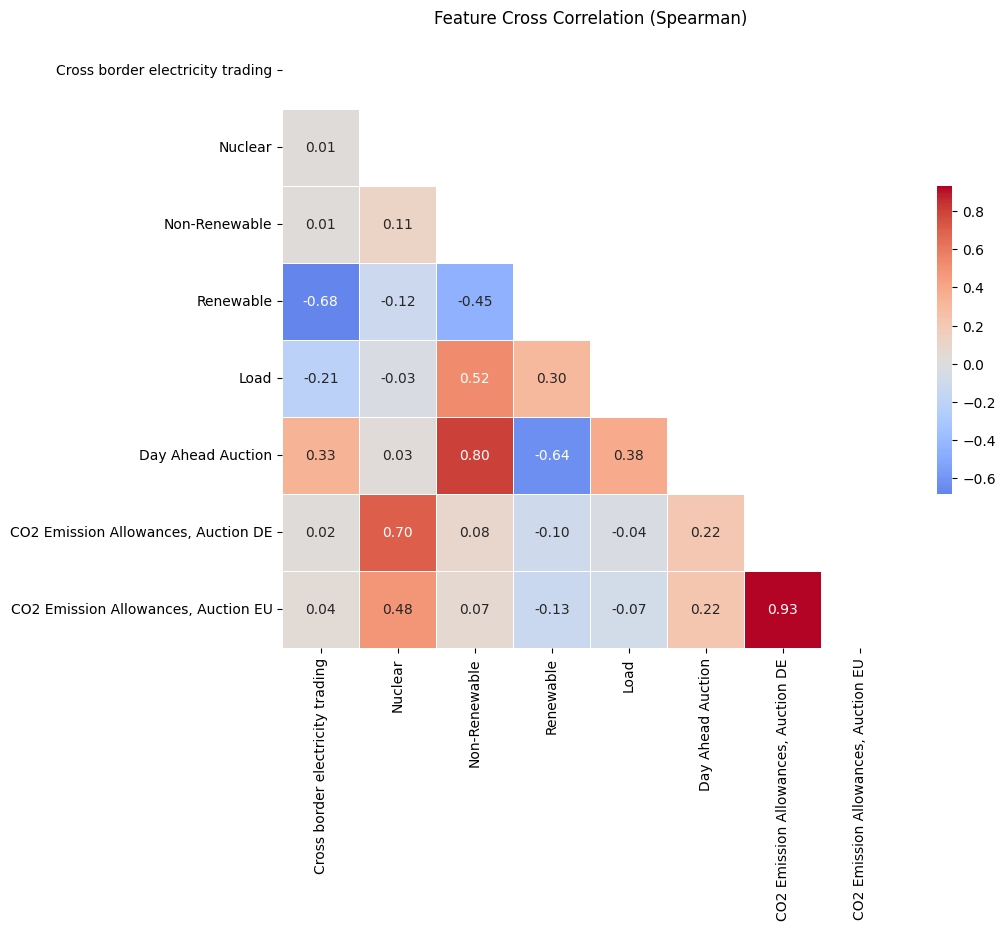

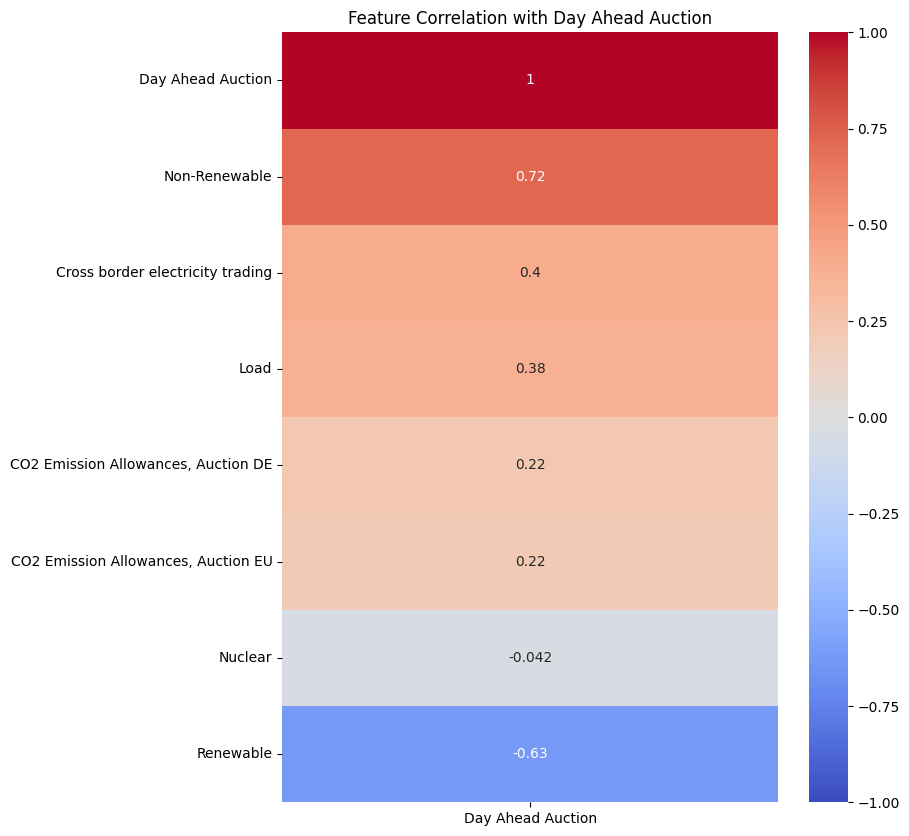

In [388]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
df.set_index('Date', inplace=True)
explore_data(df)
print("Correlation betwwen all variables")
show_cross_correlation(df,'spearman') 
show_correlation(df, target_column_name)

                     Cross border electricity trading  Non-Renewable  \
Date                                                                   
2023-01-01 00:00:00                         -12557.67        9146.69   
2023-01-01 01:00:00                         -15382.58        8925.66   
2023-01-01 02:00:00                         -16357.50        8902.44   
2023-01-01 03:00:00                         -14005.92        8901.05   
2023-01-01 04:00:00                         -14544.00        8863.19   

                     Renewable      Load  Day Ahead Auction  \
Date                                                          
2023-01-01 00:00:00   38384.86  38536.48              -5.17   
2023-01-01 01:00:00   39415.38  37935.26              -1.07   
2023-01-01 02:00:00   39610.49  37103.11              -1.47   
2023-01-01 03:00:00   37023.62  36139.27              -5.08   
2023-01-01 04:00:00   36499.65  35711.44              -4.49   

                     CO2 Emission Allowances, Auction

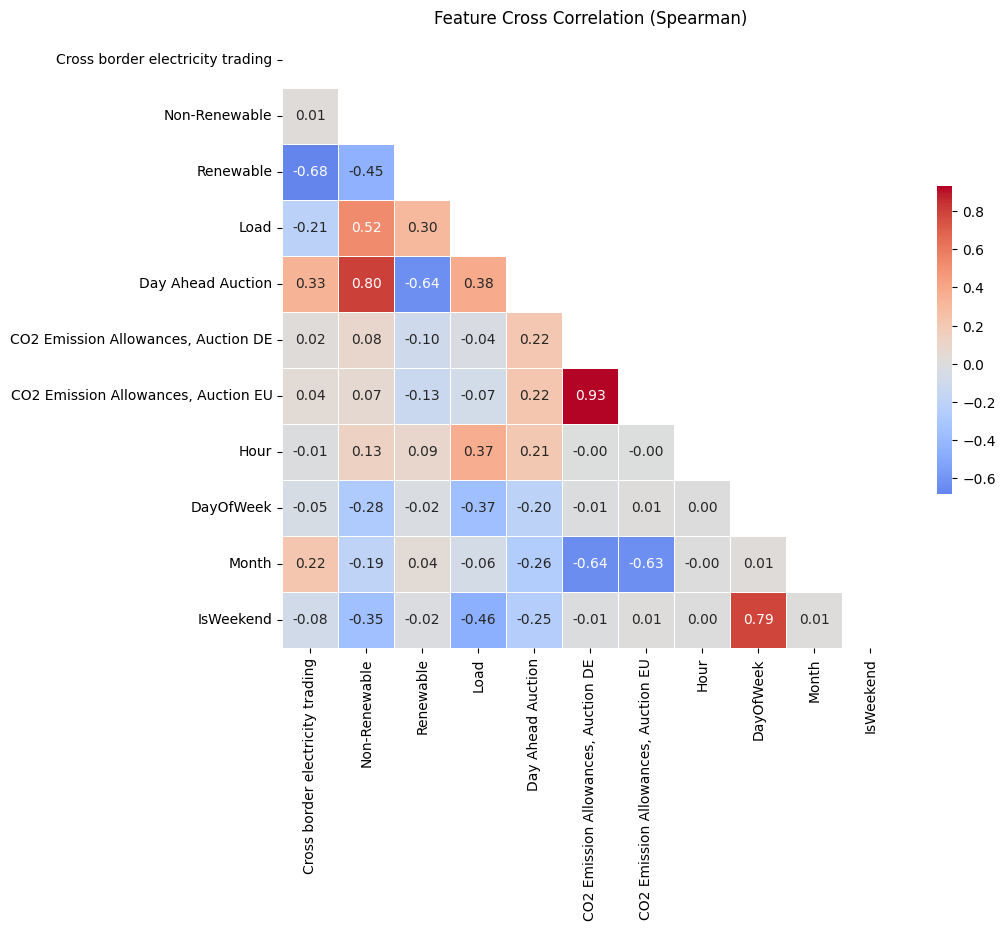

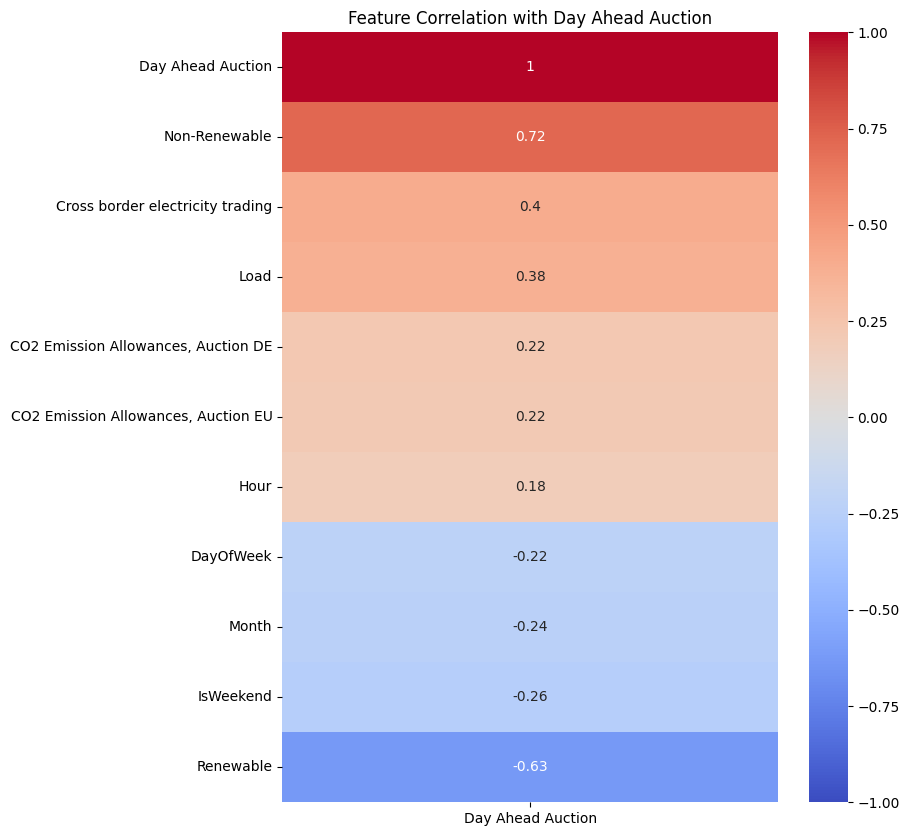

In [389]:
df = df.drop(['Nuclear'], axis=1)
df= engineer_features(df)
print(df.head())
show_cross_correlation(df,'spearman') 
show_correlation(df, target_column_name)

In [390]:
df = clean_data(df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
#X_train, X_test, y_train, y_test = time_series_split(X_scaled, y)
X_train, X_test, y_train, y_test, dates_train, dates_test = time_series_split(X_scaled, y, n_splits=5)

Make sure transformation is well done:
                     Cross border electricity trading  Non-Renewable  \
Date                                                                   
2023-01-01 00:00:00                         -1.997174      -1.094203   
2023-01-01 01:00:00                         -2.403129      -1.118782   
2023-01-01 02:00:00                         -2.543231      -1.121365   
2023-01-01 03:00:00                         -2.205295      -1.121519   
2023-01-01 04:00:00                         -2.282621      -1.125729   

                     Renewable      Load  CO2 Emission Allowances, Auction DE  \
Date                                                                            
2023-01-01 00:00:00   0.683095 -1.514019                            -0.027065   
2023-01-01 01:00:00   0.764334 -1.580404                            -0.027065   
2023-01-01 02:00:00   0.779715 -1.672287                            -0.027065   
2023-01-01 03:00:00   0.575784 -1.778711           

1. **Objective Function for SVR Optimization**:
   $$ \min_{w, b, \xi, \xi^*} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*) $$

2. **Constraints**:
   $$ y_i - w \cdot \phi(x_i) - b \leq \varepsilon + \xi_i $$
   $$ w \cdot \phi(x_i) + b - y_i \leq \varepsilon + \xi_i^* $$
   $$ \xi_i, \xi_i^* \geq 0 $$

3. **Loss Function (Epsilon-Insensitive Loss)**:
   $$ L_{\varepsilon}(y, f(x)) = \max(0, |y - f(x)| - \varepsilon) $$

4. **Kernel Trick**:
   If using the kernel trick, the optimization problem is formulated in the dual space using the kernel function $ k(x_i, x_j) $


\begin{equation}
\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2} \mathbf{w}^T\mathbf{w} + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
\end{equation}
\text{s.t.}
\begin{equation}
\begin{cases}
y_i - (\mathbf{w}^T\mathbf{x}_i + b) \leq \epsilon + \xi_i, \\
(\mathbf{w}^T\mathbf{x}_i + b) - y_i \leq \epsilon + \xi_i^*, \\
\xi_i, \xi_i^* \geq 0
\end{cases}
\end{equation}
Here, $\epsilon$ represents the maximum value of tolerable error, while $\xi_i$ and $\xi_i^*$ denote slack variables that measure the degree to which predictions can deviate from the actual values within the $\epsilon$-insensitive zone. The parameter $C$ balances the trade-off between the flatness of the SVR function and the amount up to which deviations larger than $\epsilon$ are tolerated.

\text{where } \epsilon \text{ denotes the maximum value of tolerable error, } \boldsymbol{\xi} \text{and} \boldsymbol{\xi}^* \text{ are the distances between actual values and the corresponding boundary values of } $\epsilon$text{-tube,} C > 0 \text{decides the trade-off of generalization ability and training error. This problem can be solved by making use of the Karush–Kuhn–Tucker's (KKT) conditions. Then, the traditional SVR would be the following linear regression function}
\begin{equation}
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b,
\end{equation}
\text{where} \mathbf{w} \text{represents the weight vector; } b \text{represents the bias.}

\text{By employing the "kernel trick", SVR has been extended to solve nonlinear regression problems with a linear method in an appropriate feature space. Thus, the performance of SVR is determined by the type of kernel function and the settings of kernel parameters.}

\text{The following four types of kernel function, namely linear, tanh, polynomial, and Gaussian kernels, are commonly employed in the related area. The linear kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^T\mathbf{z},
\end{equation}
\text{the tanh kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \tanh(g\mathbf{x}^T\mathbf{z} + c),
\end{equation}
\text{the polynomial kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z} + c)^d,
\end{equation}
\text{and the Gaussian kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{(\mathbf{x} - \mathbf{z})^2}{2 \sigma^2}\right),
\end{equation}
\text{where } g \text{ is the slope of the tanh kernel, } c \text{ is the offset set of polynomial and tanh kernel, } d \text{ is the degree of the polynomial kernel, and } \sigma \text{ is the width of the Gauss kernel.}


To minimize the prediction error within a specified tolerance, the objective of Support Vector Regression (SVR) is given by:

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2} \mathbf{w}^T\mathbf{w} + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
$$

The constraints ensuring that the predictions remain within the error tolerance $\epsilon$ for each observation $i$ are:

$$
\begin{aligned}
y_i - (\mathbf{w}^T\mathbf{x}_i + b) &\leq \epsilon + \xi_i, \\
(\mathbf{w}^T\mathbf{x}_i + b) - y_i &\leq \epsilon + \xi_i^*, \\
\xi_i, \xi_i^* &\geq 0
\end{aligned}
$$

Here, $\epsilon$ represents the maximum value of tolerable error, while $\xi_i$ and $\xi_i^*$ denote slack variables that measure the degree to which predictions can deviate from the actual values within the $\epsilon$-insensitive zone. The parameter $C$ balances the trade-off between the flatness of the SVR function and the amount up to which deviations larger than $\epsilon$ are tolerated.

The SVR model predicts new values using the function:

$$
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b,
$$

which is linear in the feature space. To allow for non-linear relationships, kernel functions are used to map the inputs into a higher-dimensional space, facilitating the discovery of non-linear decision boundaries.

Common kernel functions include:

Linear kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^T\mathbf{z},
$$

Tanh kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \tanh(g\mathbf{x}^T\mathbf{z} + c),
$$

Polynomial kernel:

$$
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z} + c)^d,
$$

Gaussian kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{(\mathbf{x} - \mathbf{z})^2}{2 \sigma^2}\right),
$$

Each kernel function comes with parameters that need to be fine-tuned for the model to perform optimally on the given data.


# Support Vector Regression (SVR) with Time Series Split in scikit-learn

In our study, we employ the Support Vector Regression (SVR) implementation from the `scikit-learn` library in Python to model time-series data. Time series data inherently contain temporal dependencies, so care must be taken to ensure these dependencies are preserved during model training and validation.

## Time Series Split

To validate our SVR model, we use the TimeSeriesSplit cross-validator from `scikit-learn`. This technique splits the dataset into $k$ sequential folds, each fold consisting of a contiguous time block. Unlike standard cross-validation methods that shuffle data before splitting, TimeSeriesSplit maintains the order of the samples.

The splitting of the dataset into $k$ folds is performed as follows:

1. The first fold contains the first $n_{1}$ samples as the training set, followed by the next $n_{\text{test}}$ samples as the test set.
2. The second fold includes the first $n_{1} + n_{\text{test}}$ samples in the training set, and the subsequent $n_{\text{test}}$ samples as the test set.
3. This process continues until the $k^{th}$ fold, which uses all remaining samples after the $(k-1)^{th}$ fold for training, and the remaining samples (if any) for testing.

Mathematically, for each split $i$, the training and test sets are defined as:

$$
\text{Train}_i = \{1, 2, ..., n_{1} + (i - 1) \times n_{\text{test}}\}
$$

$$
\text{Test}_i = \{n_{1} + (i - 1) \times n_{\text{test}} + 1, ..., n_{1} + i \times n_{\text{test}}\}
$$

where $n_{1}$ is the size of the initial training set and $n_{\text{test}}$ is the size of the test set in each fold.

By using this method, we ensure that the validation of our SVR model respects the temporal sequence of the data, which is crucial for the predictive accuracy of time-series models.


In [391]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}


In [392]:
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

In [393]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration

In [394]:
print(f"Calibration time for Grid Research: {calibration_time} seconds")

Calibration time for Grid Research: 121.3028552532196 seconds


In [395]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")

Calibration time for Random search: 540.6007030010223 seconds


In [396]:
start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 4.146333932876587 seconds


## Evaluation Metrics for Regression Models

We evaluate the performance of our regression models using the following metrics:

- **R-squared ($R^2$)**: The coefficient of determination, $R^2$, indicates the proportion of variance in the dependent variable that can be predicted from the independent variables. It is defined as:
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
  $$
  where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $\bar{y}$ is the mean of the actual values. An $R^2$ of 1 indicates perfect prediction accuracy.

- **Mean Squared Error (MSE)**: Measures the average of the squares of the errors, which is the average squared difference between the estimated values and the actual value.
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
  A lower MSE indicates a more accurate model.

- **Mean Absolute Error (MAE)**: Represents the average magnitude of the errors in a set of predictions, without considering their direction.
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$
  MAE is particularly useful when large errors are equally as undesirable as small ones.

- **Root Mean Square Error (RMSE)**: The square root of the mean square error, giving us the standard deviation of the residuals.
  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  $$
  RMSE can highlight large errors because they will have a disproportionately large effect on the value of the RMSE.


In [397]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)

Mean Squared Error: 357.84329883058444
Mean Absolute Error: 14.865693356169825
Root Mean Squared Error: 18.916746518114167
R^2 Score: 0.8334280375029667


In [398]:
print(f"model with random search")
evaluate_model(model2, X_test, y_test)

model with random search


Mean Squared Error: 589.6979465970348
Mean Absolute Error: 17.06007186770335
Root Mean Squared Error: 24.2836971360836
R^2 Score: 0.7255023509839623


(array([64.45659364, 78.57114038, 90.05774128, ..., 65.37016399,
        60.75305209, 58.85010947]),
 589.6979465970348,
 17.06007186770335,
 24.2836971360836,
 0.7255023509839623)

In [399]:
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)

Mean Squared Error: 589.6979465970348
Mean Absolute Error: 17.06007186770335
Root Mean Squared Error: 24.2836971360836
R^2 Score: 0.7255023509839623


In [400]:
def autocorrel(target_column, lag, title="Autocorrelation Function"):
    plot_acf(target_column, lags= lag)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.show()

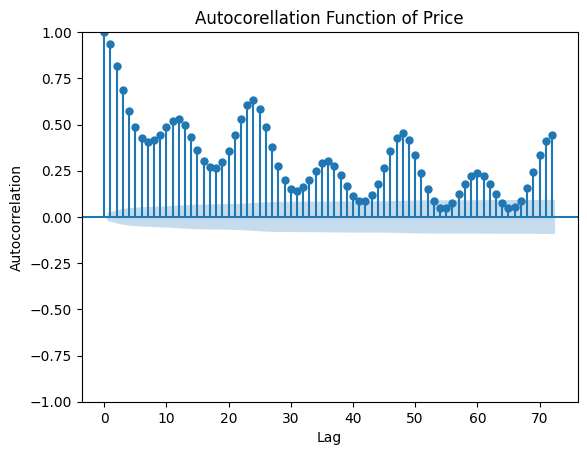

In [401]:
autocorrel(df["Day Ahead Auction"], 72, "Autocorellation Function of Price")

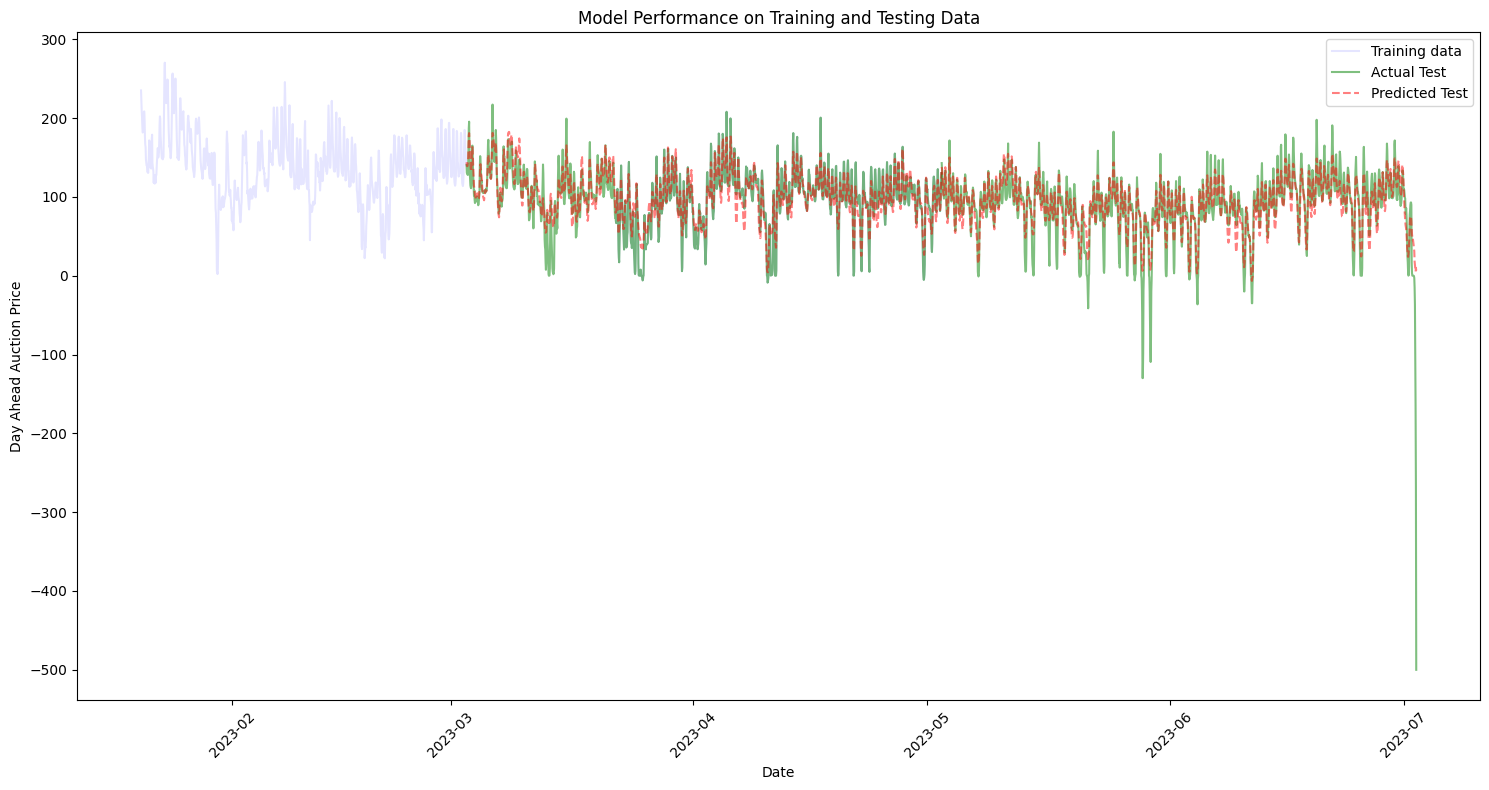

In [402]:
plot_training_testing(model, X_scaled, y, dates_train[:2], dates_test[:2])  # Example for first two splits

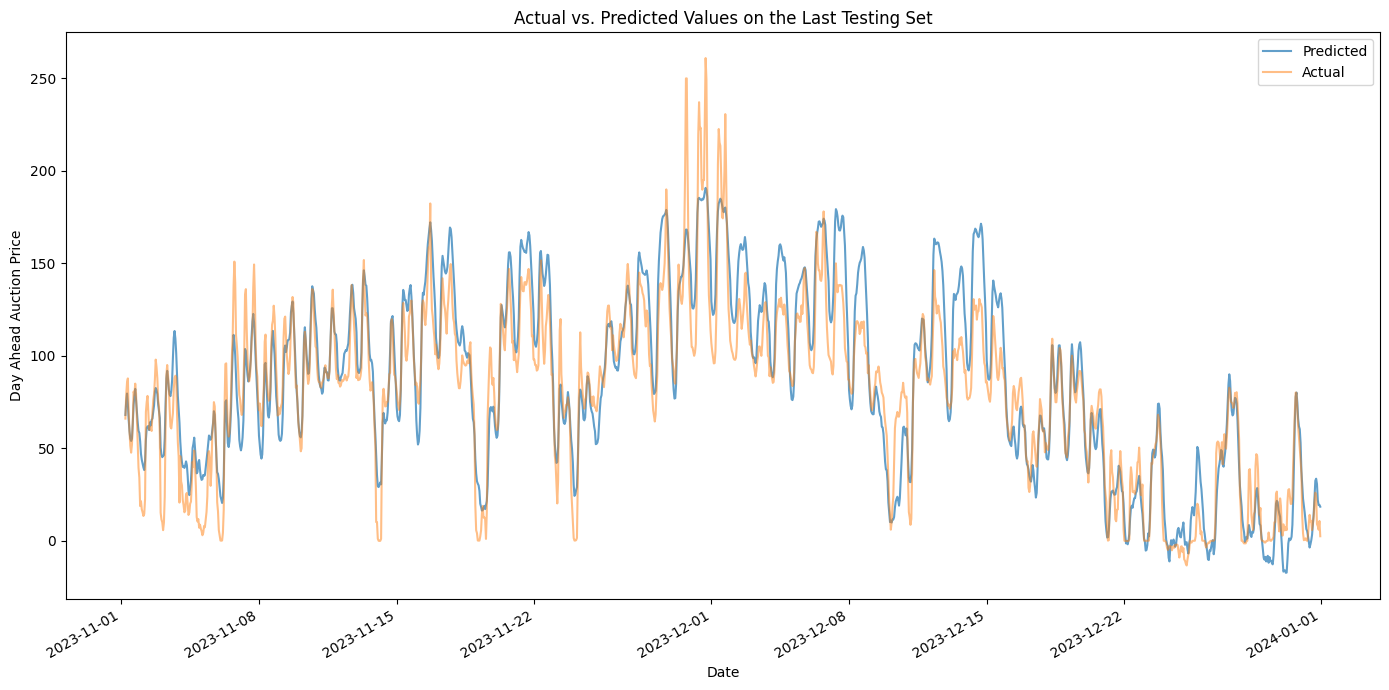

In [403]:
plot_last_test_set_predictions(model, X_scaled, y, dates_train, dates_test)

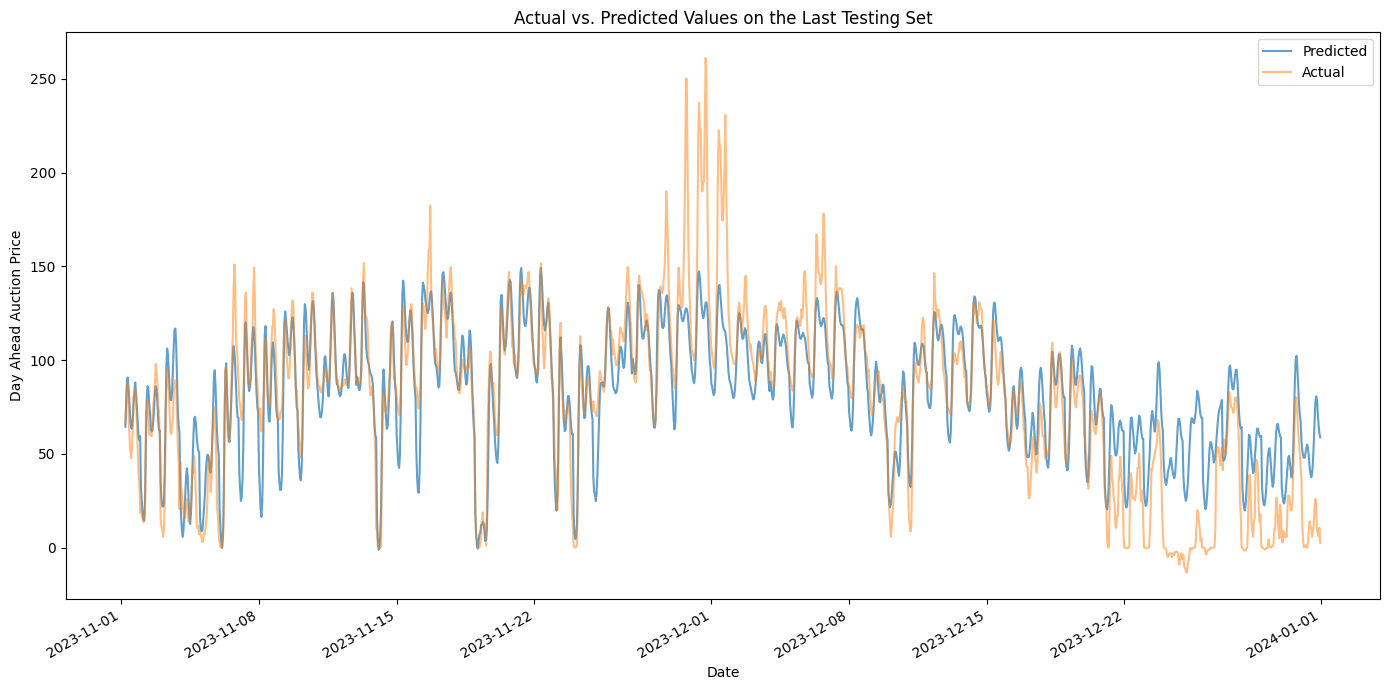

In [404]:
plot_last_test_set_predictions(model2, X_scaled, y, dates_train, dates_test)

We remark that the model with random search got better R2 and better MAE, but it fails to predict the spikes 

Let's get back to something that we had to do before. look at the correalation between teh price and teh features


SVR and ARIMA

The forecasting model developed in this study employs a sequential two-step approach to address the inherent complexities in the time series data of electricity spot prices. Initially, the model implements a Seasonal and Trend decomposition using Loess (STL), a non-parametric method that isolates the time series into three distinct components: trend, seasonality, and the remainder (residuals). This decomposition facilitates a clearer analysis by separating the systematic structures and the more stochastic or irregular fluctuations within the data.

The trend component reflects the long-term progression of the prices, encapsulating shifts that are not of a fixed frequency. The seasonal component captures regular patterns that recur over fixed periods, such as daily or weekly cycles commonly observed in electricity prices. The remainder, composed of residuals, represents the non-systematic variation unaccounted for by the trend and seasonal components.

Following the decomposition, the residuals — now stripped of the trend and seasonal influences — undergo modeling via an Autoregressive Integrated Moving Average (ARIMA) process. This step aims to model the autocorrelated structure of the residuals, focusing on the internal dynamics of the time series data that are not explained by the deterministic components extracted earlier.

we will restart the treatment of the data 

In [405]:
from statsmodels.tsa.seasonal import STL

In [406]:
import statsmodels.api as sm
def test_stationnarity(data):
    result = sm.tsa.adfuller(data)

    # Afficher les résultats
    print('Valeur de la statistique ADF :', result[0])
    print('p-valeur :', result[1])
    print('Valeurs critiques :', result[4])

    if result[0] < result[4]['5%']:
        print("La série est stationnaire.")
        return  True
    else:
        print("La série n'est pas stationnaire.")
        return False

In [407]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
df.set_index('Date', inplace=True)
clean_data(df)

,Cross border electricity trading,Nuclear,Non-Renewable,Renewable,Load,Day Ahead Auction,"CO2 Emission Allowances, Auction DE","CO2 Emission Allowances, Auction EU"
Date,,,,,,,,
2023-01-01 00:00:00,-12557.67,2459.170000,9146.69,38384.86,38536.48,-5.17,83.41,84.10
2023-01-01 01:00:00,-15382.58,2458.600000,8925.66,39415.38,37935.26,-1.07,83.41,84.10
2023-01-01 02:00:00,-16357.50,2459.640000,8902.44,39610.49,37103.11,-1.47,83.41,84.10
2023-01-01 03:00:00,-14005.92,2460.480000,8901.05,37023.62,36139.27,-5.08,83.41,84.10
2023-01-01 04:00:00,-14544.00,2460.800000,8863.19,36499.65,35711.44,-4.49,83.41,84.10
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-7090.11,2671.735395,8956.61,43212.24,49266.05,9.00,66.60,66.49
2023-12-31 20:00:00,-8253.64,2671.735395,8651.99,43930.70,46113.86,7.95,66.60,66.49
2023-12-31 21:00:00,-8682.10,2671.735395,8651.99,43803.16,44018.78,6.00,66.60,66.49


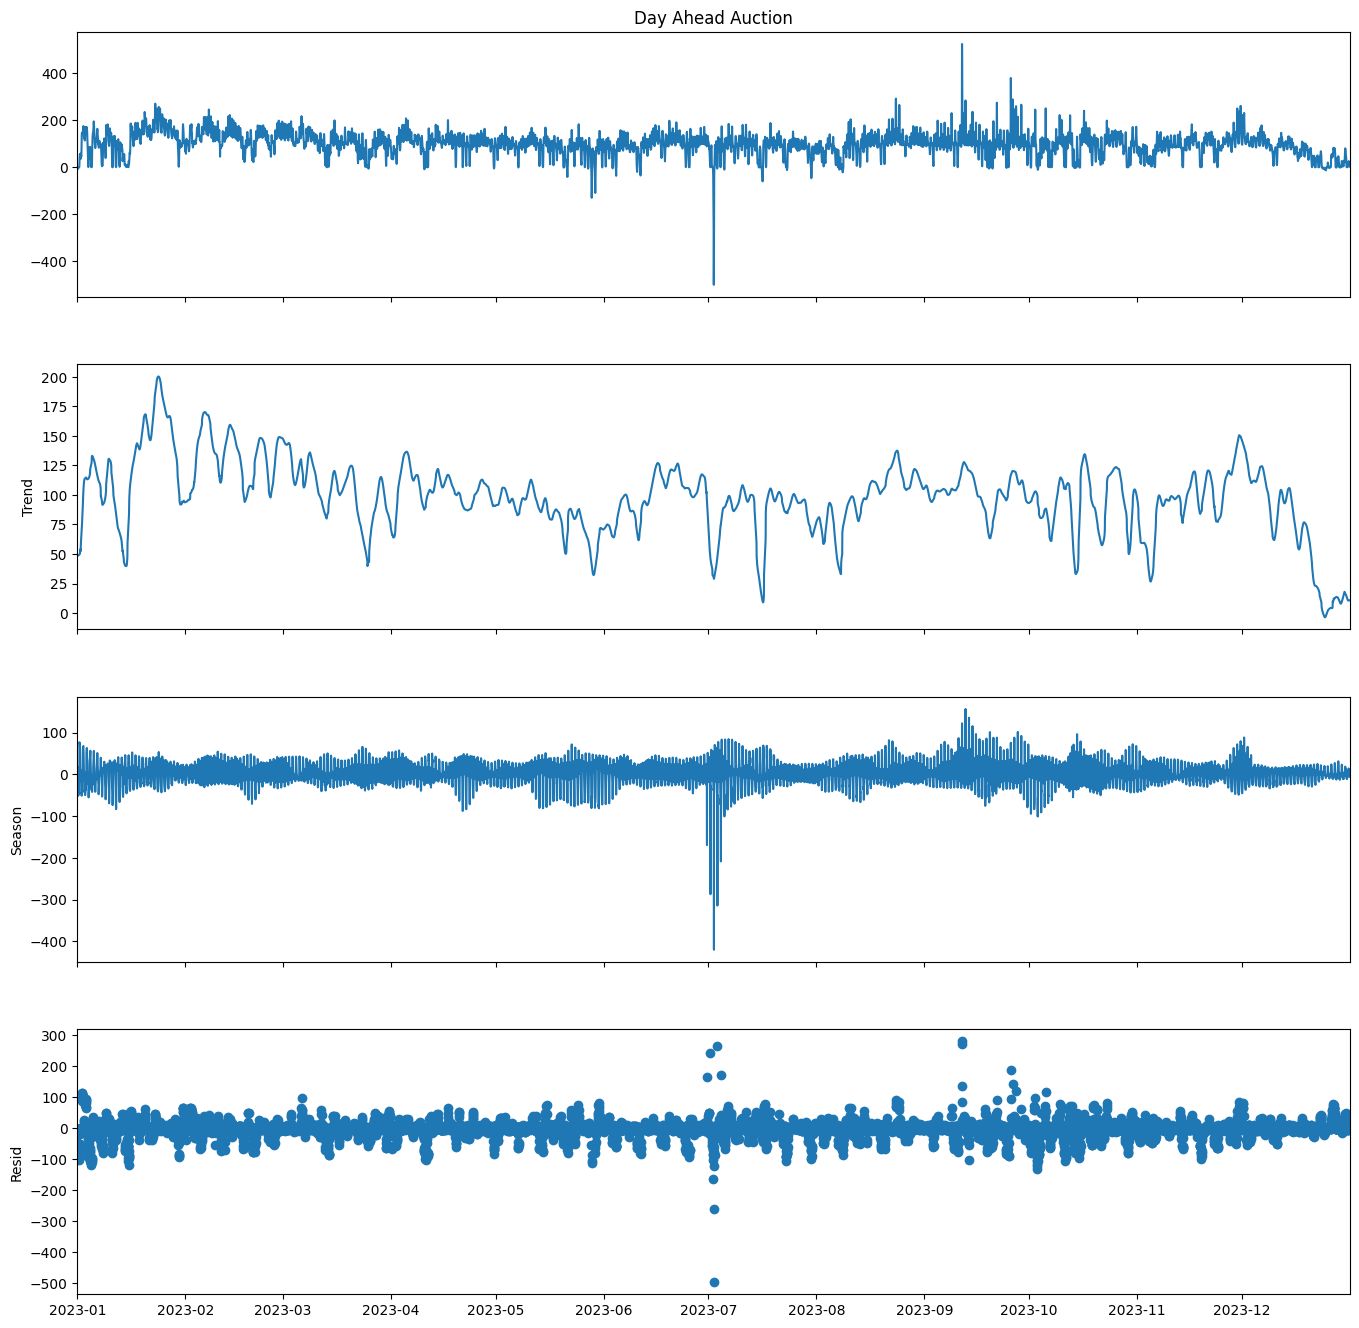

In [408]:
stl= STL(df[target_column_name], period= 24, robust= True)
result = stl.fit()
fig= result.plot()
plt.gcf().set_size_inches(15, 15) 
plt.show()

Here's a more detailed breakdown of the three components:

Trend: This component reflects the long-term progression or decline in the dataset, showing how the central tendency changes over time. The trend can go up or down and typically changes relatively slowly.
Seasonal: The seasonal component captures regular, predictable cycles or patterns within a fixed period, such as daily, weekly, monthly, or yearly fluctuations. For example, in electricity price data, you might see higher prices during the day and lower prices at night, repeating every 24 hours.
Residual: After the seasonal and trend components are accounted for, the residual component is what's left. It includes:
Random fluctuations: These are the unpredictable and random changes in the time series that do not follow any discernible pattern.
Outliers: Extreme values or spikes that are not explained by the seasonal or trend patterns.
Irregularities: Any other unexplained variations in the time series data.

In [409]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

def forecast_arima(data, target_variable):
    # Ensure all data points are positive by adding an offset
    minimum_value = data[target_variable].min()
    offset = 1 - minimum_value if minimum_value <= 0 else 0
    #data['shifted'] = data[target_variable] + offset

    # Box-Cox Transformation
   # if any(data['shifted'] <= 0):  # Double-check if any non-positive values exist
     #  raise ValueError("Offset failed to make all data positive. Please check data values and offset calculation.")
    
   # data['transformed'], lambda_ = boxcox(data['shifted'])

    # STL Decomposition
    stl = STL(data[target_variable], period=24, robust=True)
    result = stl.fit()

    # ARIMA on Residuals
    #make sure that we got stationnarity
    if(test_stationnarity(result.resid)):
      model = pm.auto_arima(result.resid, seasonal=False, stepwise=True, suppress_warnings=True)
      arima_model = ARIMA(result.resid, order=model.order)
      arima_result = arima_model.fit()
      resid_forecast = arima_result.forecast(steps=24)
    else :
       raise  ValueError("The time series is not stationary")
    # Reseasonalize by adding the most recent seasonal component
    final_forecast = resid_forecast + result.seasonal[-1]

    # Inverse Box-Cox Transformation
    #final_forecast_original_scale = inv_boxcox(final_forecast, lambda_) - offset

    return final_forecast

In [410]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
df.set_index('Date', inplace=True)
clean_data(df)

,Cross border electricity trading,Nuclear,Non-Renewable,Renewable,Load,Day Ahead Auction,"CO2 Emission Allowances, Auction DE","CO2 Emission Allowances, Auction EU"
Date,,,,,,,,
2023-01-01 00:00:00,-12557.67,2459.170000,9146.69,38384.86,38536.48,-5.17,83.41,84.10
2023-01-01 01:00:00,-15382.58,2458.600000,8925.66,39415.38,37935.26,-1.07,83.41,84.10
2023-01-01 02:00:00,-16357.50,2459.640000,8902.44,39610.49,37103.11,-1.47,83.41,84.10
2023-01-01 03:00:00,-14005.92,2460.480000,8901.05,37023.62,36139.27,-5.08,83.41,84.10
2023-01-01 04:00:00,-14544.00,2460.800000,8863.19,36499.65,35711.44,-4.49,83.41,84.10
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-7090.11,2671.735395,8956.61,43212.24,49266.05,9.00,66.60,66.49
2023-12-31 20:00:00,-8253.64,2671.735395,8651.99,43930.70,46113.86,7.95,66.60,66.49
2023-12-31 21:00:00,-8682.10,2671.735395,8651.99,43803.16,44018.78,6.00,66.60,66.49


In [416]:
def rolling_forecast_arima_stl(data, target_variable, start_period, end_period, window_size='60D', forecast_horizon=24):
    # Convert index to datetime and handle duplicates
    data.index = pd.to_datetime(data.index)
    if data.index.duplicated().any():
        data = data.groupby(data.index).mean()  # Aggregate duplicates
    
    # Ensure hourly frequency
    data = data.resample('H').ffill()

    start_date = pd.to_datetime(start_period)
    end_date = pd.to_datetime(end_period)
    
    forecasts = []

    while start_date + pd.Timedelta(window_size) <= end_date:
        # Define the window of data to train on
        end_window = start_date + pd.Timedelta(window_size)
        train_data = data.loc[start_date:end_window]

        # Apply STL decomposition and fit ARIMA to residuals
        stl = STL(train_data[target_variable], period=24, robust=True)
        result = stl.fit()

        # Fit the ARIMA model
        model = pm.auto_arima(result.resid, seasonal=False, stepwise=True, suppress_warnings=True)
        fitted_model = ARIMA(result.resid, order=model.order).fit()

        # Forecast the next 24 hours (or forecast_horizon)
        forecast = fitted_model.forecast(steps=forecast_horizon)

        # Store the forecast and corresponding dates
        forecast_dates = pd.date_range(start=end_window, periods=forecast_horizon, freq='H')
        forecasts.append(pd.Series(forecast, index=forecast_dates))

        # Increment start_date by one day
        start_date += pd.Timedelta('1D')

    # Concatenate all individual forecasts into one Series
    forecast_series = pd.concat(forecasts)

    return forecast_series

In [417]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

def rolling_forecast_arima_stl2(data, target_variable, window_size='60D', forecast_horizon=24):
    # Assuming 'data' has an hourly index, i.e., frequency is set to 'H'
    forecasts = []

    start_date = data.index.min()
    end_date = data.index.max()
    print(f" the start: {start_date}, the end {end_date}, window_size: {window_size}")
    while start_date + pd.Timedelta(window_size) <= end_date:
        # Define the window of data to train on
        end_window = start_date + pd.Timedelta(window_size)
        train_data = data.loc[start_date:end_window]

        # Apply STL decomposition and fit ARIMA to residuals
        stl = STL(train_data[target_variable], period=24, robust=True)
        result = stl.fit()

        # Fit the ARIMA model
        model = pm.auto_arima(result.resid, seasonal=False, stepwise=True, suppress_warnings=True)
        fitted_model = ARIMA(result.resid, order=model.order).fit()

        # Forecast the next 24 hours (or forecast_horizon)
        forecast = fitted_model.forecast(steps=forecast_horizon)

        # Store the forecast and corresponding dates
        forecast_dates = pd.date_range(start=end_window, periods=forecast_horizon, freq='H')
        forecasts.append(pd.Series(forecast, index=forecast_dates))

        # Increment start_date by one day
        start_date += pd.Timedelta('1D')

    # Concatenate all individual forecasts into one Series
    forecast_series = pd.concat(forecasts)

    return forecast_series

In [418]:
test_stationnarity(df[target_column_name])

Valeur de la statistique ADF : -8.876746020367309
p-valeur : 1.3515386066736821e-14
Valeurs critiques : {'1%': -3.4311000545606776, '5%': -2.861871474145309, '10%': -2.566946438722175}
La série est stationnaire.


True

In [412]:
## Juste un test 

# Ensure all data points are positive by adding an offset
data = df.copy()
target_variable= target_column_name
print("negatives values")
negative_values = data[data[target_variable] < 0]
negative_values.describe()
minimum_value = df[target_variable].min()
print(minimum_value)
offset = 1 - minimum_value if minimum_value <= 0 else 0
data['shifted'] = data[target_variable] + offset
print(data['shifted'])
data['shifted'].describe()

negatives values
-500.0
Date
2023-01-01 00:00:00    495.83
2023-01-01 01:00:00    499.93
2023-01-01 02:00:00    499.53
2023-01-01 03:00:00    495.92
2023-01-01 04:00:00    496.51
                        ...  
2023-12-31 19:00:00    510.00
2023-12-31 20:00:00    508.95
2023-12-31 21:00:00    507.00
2023-12-31 22:00:00    511.68
2023-12-31 23:00:00    503.44
Name: shifted, Length: 8759, dtype: float64


count    8759.000000
mean      596.186317
std        47.576064
min         1.000000
25%       576.885000
50%       599.020000
75%       623.120000
max      1025.270000
Name: shifted, dtype: float64

# First, ensure your date index is sorted
resid_with_freq.sort_index(inplace=True)

# Check for continuity and uniform spacing


# Try setting the frequency now
try:
    resid_with_freq.index.freq = 'H'
except ValueError as e:
    print("Failed to set frequency directly due to:", e)
    # Try interpolating or filling gaps then set the frequency
    resid_with_freq = resid_with_freq.resample('H').mean()  # Fill with mean or another suitable method
    resid_with_freq.index.freq = 'H'  # Now try setting the frequency again

# Continue with ARIMA modeling
arima_model = ARIMA(resid_with_freq, order=model.order)
arima_result = arima_model.fit()


The warnings you're encountering indicate a few key issues in how your data and models are being handled:

Frequency Information Missing: This warning suggests that your date index doesn't have a defined frequency (like daily, monthly), which is essential for forecasting models in statsmodels to understand how to increment dates in predictions.
Convergence Warning: Indicates that the maximum likelihood estimation (MLE) for the ARIMA model didn't converge, which might suggest issues with the model specification or the data's suitability for the model.
Index Issues in Forecasting: This warning shows that the lack of a frequency in your date index leads to results being indexed by integers rather than dates, which can make interpreting results more challenging.
Deprecation Warning about Series Indexing: Points out an upcoming change in how pandas will handle integer indexing.

In [420]:

# test 
'''
        We had a big problem in the data as there are duplicated data in the index, it is related to the changement of time in the summer and in the winter 
        so this function should be executed at the cleanining and it will get you the date that should be manually modified
        in our case 
        output:
        Duplicates found in the index. Printing the first 10 occurrences:
        DatetimeIndex(['2023-02-26 02:00:00', '2023-09-29 05:00:00',
               '2023-10-29 02:00:00'],
              dtype='datetime64[ns]', name='Date', freq=None)
'''
data = df.copy()
data.index = pd.to_datetime(data.index)
    
duplicated_index = data.index[data.index.duplicated(keep='first')]
num_duplicates = len(duplicated_index)

if num_duplicates > 0:
    print("Duplicates found in the index. Printing the first 10 occurrences:")
    print(duplicated_index[:10])
else:
    print("no duplicates")

no duplicates


In [419]:
# Slice your data to the first three months

start_period = '2023-01-01'
end_period = '2023-03-31'
forecasted_prices = rolling_forecast_arima_stl(df, 'Day Ahead Auction', start_period, end_period)

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_24300/64445718.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').ffill()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

no duplicates


In [421]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

def rolling_forecast_arima_stlNew(data, target_variable, start_period, end_period, window_size='60D', forecast_horizon=24):
    # Convert index to datetime if it's not already
    data.index = pd.to_datetime(data.index)
    
    # Check for duplicates
    if data.index.duplicated().any():
        print("Duplicates found in the index. Handling duplicates by keeping the first occurrence.")
        data = data.loc[~data.index.duplicated(keep='first')]
    
    # Ensure the index is continuous without gaps
    if not data.index.freq:
        data = data.asfreq('h', method='ffill')  # Assuming you want to forward-fill missing data
    
    # Set the datetime range for the forecast
    start_date = pd.to_datetime(start_period)
    end_date = pd.to_datetime(end_period)
    
    forecasts = []

    while start_date + pd.Timedelta(window_size) <= end_date:
        end_window = start_date + pd.Timedelta(window_size)
        train_data = data.loc[start_date:end_window]

        stl = STL(train_data[target_variable], period=24, robust=True)
        result = stl.fit()

        try:
            test_stationnarity(result.resid)
            model = pm.auto_arima(result.resid, seasonal=False, stepwise=True, suppress_warnings=True)
            fitted_model = ARIMA(result.resid, order=model.order).fit()
            forecast = fitted_model.forecast(steps=forecast_horizon)

            forecast_dates = pd.date_range(start=end_window, periods=forecast_horizon, freq='h')
            forecasts.append(pd.Series(forecast, index=forecast_dates))

        except Exception as e:
            print(f"Failed to fit model on data ending in {end_window}: {e}")
        
        start_date += pd.Timedelta('1d')

    forecast_series = pd.concat(forecasts)
    return forecast_series



In [ ]:

start_period = '2023-01-01'
end_period = '2023-03-31'
forecasted_prices = rolling_forecast_arima_stlNew(df, 'Day Ahead Auction', start_period, end_period)

Valeur de la statistique ADF : -8.972263877842446
p-valeur : 7.696953948208434e-15
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.869233273846428
p-valeur : 4.0362891134337406e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.733752689923012
p-valeur : 8.862237390979286e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.067830775547941
p-valeur : 1.2822443203741241e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.759848780332097
p-valeur : 7.61460039268764e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.86466598543701
p-valeur : 4.14451912183821e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.659312834162723
p-valeur : 1.3670124014587552e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.447348122846538
p-valeur : 4.716546843679907e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.613557735847989
p-valeur : 1.7850466008515333e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.6765820965797
p-valeur : 1.2361528679659638e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.411950740817167
p-valeur : 5.80338879075966e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -8.902629850518556
p-valeur : 1.1602705563589673e-14
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.944065398628576
p-valeur : 2.6177916700856934e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.980828170220025
p-valeur : 2.1170161570389755e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.446489775568976
p-valeur : 4.740315131738898e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.930995699252309
p-valeur : 2.823221776886607e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.04016523491919
p-valeur : 1.503624398065707e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -10.07396120384571
p-valeur : 1.2378077236033609e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.135769090894206
p-valeur : 8.677933250931956e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -9.93393501552562
p-valeur : 2.775651570324606e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.10481298999968
p-valeur : 1.0366200915909332e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Valeur de la statistique ADF : -10.307641241542894
p-valeur : 3.2472433728212615e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.243210718979297
p-valeur : 4.690221388105814e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Valeur de la statistique ADF : -10.318350269972383
p-valeur : 3.0550446414261297e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.880073656011888
p-valeur : 3.790644943791618e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.016401294876559
p-valeur : 1.7242835244593e-17
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valeur de la statistique ADF : -10.240479042105799
p-valeur : 4.7640127476151885e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.194144893705985
p-valeur : 6.209882226819672e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -10.302200887240703
p-valeur : 3.3495049054739794e-18
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.
Valeur de la statistique ADF : -9.447251784696606
p-valeur : 4.719208551780449e-16
Valeurs critiques : {'1%': -3.434976549531161, '5%': -2.86358329808087, '10%': -2.5678578416363433}
La série est stationnaire.


It seems like your series is confirmed as stationary by the Dickey-Fuller test, which is good because it means there's no need for differencing to stabilize the mean. However, the warnings from the ARIMA modeling process indicate some issues:

Non-stationary starting autoregressive parameters: This warning is indicating that the initial values provided to the model for the autoregressive (AR) part are not conducive to a stationary process. Even though your data itself is stationary, the parameters (p-values) being tried by the model may not be appropriate.
Non-invertible starting MA parameters: Similarly, this warning suggests that the initial values for the moving average (MA) parameters may not lead to a valid, invertible MA process. An MA model is invertible if it can be written as an infinite-order AR process.
Convergence issues: This is telling you that the optimization algorithm used to estimate the ARIMA model's parameters failed to find the best values within the allowed iterations or that the solution found is not optimal. This might happen if the model is overparameterized (too complex relative to the data) or if the data itself doesn't well support the chosen model.
Addressing the Issues
To address these issues, consider the following steps:

Simplify the model: Reduce the complexity of your ARIMA model. If auto_arima is automatically selecting a very high order for AR or MA components, you might want to manually limit these. High order models can be more sensitive and prone to overfitting or numerical instabilities.
Increase iterations or change optimization settings: Sometimes, the optimizer might need more iterations to converge, or a different optimization algorithm might work better. You can adjust these settings in auto_arima and ARIMA model fitting.
Initial parameter values: If you have domain knowledge or previous studies to draw upon, setting more appropriate initial values for AR and MA parameters might help.


In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def rolling_forecast_arima_stlNewWithConstraint(data, target_variable, start_period, end_period, window_size='60D', forecast_horizon=24):
    # Convert index to datetime if it's not already and set the frequency
    data.index = pd.to_datetime(data.index, errors='coerce').to_period('H')

    # Check for duplicates
    if data.index.duplicated().any():
        logging.info("Duplicates found in the index. Handling duplicates by keeping the first occurrence.")
        data = data.loc[~data.index.duplicated(keep='first')]

    # Set the datetime range for the forecast
    start_date = pd.Period(start_period, freq='H')
    end_date = pd.Period(end_period, freq='H')
    
    forecasts = []

    while start_date + pd.Timedelta(window_size) <= end_date:
        end_window = start_date + pd.Timedelta(window_size)
        train_data = data.loc[start_date:end_window]

        stl = STL(train_data[target_variable], period=24, robust=True)
        result = stl.fit()

        try:
            test_stationnarity
            model = pm.auto_arima(result.resid, seasonal=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3, error_action='ignore')
            fitted_model = ARIMA(result.resid, order=model.order).fit()
            forecast = fitted_model.forecast(steps=forecast_horizon)

            forecast_dates = pd.date_range(start=end_window.start_time, periods=forecast_horizon, freq='H')
            forecasts.append(pd.Series(forecast, index=forecast_dates))

        except Exception as e:
            logging.error(f"Failed to fit model on data ending in {end_window}: {e}")
        
        start_date += pd.Timedelta('1D')

    forecast_series = pd.concat(forecasts)
    return forecast_series


In [ ]:
start_period = '2023-01-01'
end_period = '2023-03-31'
forecasted_prices = rolling_forecast_arima_stlNewWithConstraint(df, 'Day Ahead Auction', start_period, end_period)

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_24300/129676703.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data.index = pd.to_datetime(data.index, errors='coerce').to_period('H')
2024-04-22 18:22:31,856 - INFO - Duplicates found in the index. Handling duplicates by keeping the first occurrence.


KeyError: Period('2023-01-01 00:00', 'h')